In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import time

# Set up matplotlib
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

# Check available GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs found: {num_gpus}")

def to_onehot(x, n):
    x_onehot = np.zeros((len(x), n), dtype=np.int64)
    for i in range(len(x)):
        x_onehot[i, x[i]] = 1
    return x_onehot

def corr_finder(states, test_trials, tr_len, state_size):    
    states = states.cpu().detach().numpy()
    test0 = np.where(test_trials==0)[0]
    test0_act = np.zeros((tr_len, state_size, len(test0)))
    count = 0
    for i in test0:
        test0_act[:,:,count] = states[i*tr_len: (i+1)*tr_len,:]
        count = count + 1

    test1 = np.where(test_trials==1)[0]
    test1_act = np.zeros((tr_len, state_size, len(test1)))
    count = 0
    for i in test1:
        test1_act[:,:,count] = states[i*tr_len: (i+1)*tr_len,:]
        count = count + 1
    corrplot = np.corrcoef(np.mean(test0_act, axis=2), np.mean(test1_act, axis=2))
    return corrplot

class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # LSTM cell
        self.lstm_cell = nn.LSTMCell(input_size, hidden_size)

    def forward(self, x):
        # x shape: (sequence_length, input_size)
        h_t = torch.zeros(1, self.hidden_size, device=x.device)
        c_t = torch.zeros(1, self.hidden_size, device=x.device)
        
        # Outputs
        h_seq = []
        c_seq = []
        
        # Iterate through the sequence
        for t in range(x.size(0)):
            h_t, c_t = self.lstm_cell(x[t].unsqueeze(0), (h_t, c_t))
            h_seq.append(h_t)
            c_seq.append(c_t)
        
        # Stack the outputs
        h_seq = torch.cat(h_seq, dim=0)
        c_seq = torch.cat(c_seq, dim=0)
        
        return h_seq, c_seq

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = CustomLSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        # x shape: (sequence_length, input_size)
        
        # Pass through LSTM
        h_seq, c_seq = self.lstm(x)
        
        # h_seq shape: (sequence_length, hidden_size)
        # c_seq shape: (sequence_length, hidden_size)
        
        # Pass through fully connected layer
        out = self.fc(h_seq)  # Shape: (sequence_length, output_size)
        
        return out, h_seq, c_seq


def run_simulation(gpu_id, seeds, shared_dict):
    torch.cuda.set_device(gpu_id)
    device = torch.device(f"cuda:{gpu_id}")
    
#     trial1x = np.array([1,1,1,1,1,1,2,2,2,2,1,1,1,4,6,1,1,1,5,5,1,1,0])
#     trial2x = np.array([1,1,1,1,1,1,3,3,3,3,1,1,1,4,4,1,1,1,5,6,1,1,0])
    
    ## unique symbols for each position
    trial1x = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

    trial2x = np.array([ 0,  1,  2,  3,  4,  5,  6,  23,  24,  25, 26, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

    num_trials = 100
    num_trials_train = 50
    tr_len = len(trial1x)
    OBS = len(np.unique(np.concatenate((trial1x, trial2x))))
    input_size = OBS
    hidden_size = 500
    output_size = OBS
    epochs = 2000
    save_each = 10

    loss_all = np.zeros((len(seeds), int(epochs/save_each)))
    hidden_corr_curve = np.zeros((len(seeds), int(epochs/save_each), tr_len*2, tr_len*2))
    cell_corr_curve = np.zeros((len(seeds), int(epochs/save_each), tr_len*2, tr_len*2))
    accuracy_curve_all_test = np.zeros((len(seeds), int(epochs/save_each)))
    
    for idx, seed in enumerate(seeds):
        print(f'GPU {gpu_id}: Starting simulation {idx+1}/{len(seeds)} with seed {seed}')
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        lstm = LSTM(input_size, hidden_size, output_size).to(device)
        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.Adam(lstm.parameters(), lr=3e-3)
        
        total_train_time = 0

        for epoch in range(epochs):
            epoch_start_time = time.time()
            
            found_trials = False
            while not found_trials:
                trials = np.random.choice(2, num_trials)
                if np.sum(trials[:num_trials_train]==1)>1 and np.sum(trials[:num_trials_train]==0)>1:
                    found_trials = True
            x = np.zeros(num_trials*tr_len, dtype=np.int64)

            for trial in range(len(trials)):
                if trials[trial] == 0:
                    x[trial*tr_len: (trial+1)*tr_len] = trial1x
                else:
                    x[trial*tr_len: (trial+1)*tr_len] = trial2x

            x = to_onehot(x, OBS)
            
            train_x = torch.tensor(x[0:num_trials_train*tr_len], dtype=torch.float32).to(device)
            test_x = torch.tensor(x[num_trials_train*tr_len:], dtype=torch.float32).to(device)

            optimizer.zero_grad()
            input_x = train_x[:-1]

            prediction, hidden_all, c_states = lstm(input_x)

            # Calculate main loss
            main_loss = loss_func(prediction, train_x[1:].argmax(axis=1))

            # Combine losses
            total_loss = main_loss

            total_loss.backward()
            optimizer.step()
            
            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time
            total_train_time += epoch_duration
            
            if epoch % save_each == 0:
                with torch.no_grad():
                    pred_test, hidden_test, c_test = lstm(test_x) 
                    actual_reward = np.where(test_x[1:].cpu().argmax(axis=1) == 6)
                    predicted_reward = np.where(pred_test.cpu().argmax(axis=1) == 6)
                    accuracy = len(np.intersect1d(actual_reward, predicted_reward)) / len(actual_reward[0])
                    accuracy_curve_all_test[idx, int(epoch/save_each)] = accuracy

                    hidden_corr_curve[idx, int(epoch/save_each)] = corr_finder(hidden_test, trials[num_trials_train:], tr_len, hidden_size)
                    cell_corr_curve[idx, int(epoch/save_each)] = corr_finder(c_test, trials[num_trials_train:], tr_len, hidden_size)

                    loss_all[idx, int(epoch/save_each)] = main_loss.item()
                
                print(f"GPU {gpu_id}, Sim {idx+1}, Epoch {epoch}/{epochs} - Main Loss: {main_loss.item():.4f} - Accuracy: {accuracy:.4f}")

        print(f"GPU {gpu_id}: Simulation {idx+1} completed. Total training time: {total_train_time:.2f} seconds")
    shared_dict[gpu_id] = {
        'loss_all': loss_all,
        'hidden_corr_curve': hidden_corr_curve,
        'cell_corr_curve': cell_corr_curve,
        'accuracy_curve_all_test': accuracy_curve_all_test
    }
    
if __name__ == "__main__":
    total_simulations = 4
    seeds_per_gpu = total_simulations // num_gpus
    remaining_seeds = total_simulations % num_gpus

    all_seeds = np.arange(10, 10 + total_simulations)
    
    manager = mp.Manager()
    shared_dict = manager.dict()

    processes = []
    start_idx = 0
    for i in range(num_gpus):
        end_idx = start_idx + seeds_per_gpu + (1 if i < remaining_seeds else 0)
        gpu_seeds = all_seeds[start_idx:end_idx]
        p = mp.Process(target=run_simulation, args=(i, gpu_seeds, shared_dict))
        p.start()
        processes.append(p)
        start_idx = end_idx

    for p in processes:
        p.join()

    # Combine results from all GPUs
    combined_loss_all = np.concatenate([shared_dict[i]['loss_all'] for i in range(num_gpus)])
    combined_hidden_corr_curve = np.concatenate([shared_dict[i]['hidden_corr_curve'] for i in range(num_gpus)])
    combined_cell_corr_curve = np.concatenate([shared_dict[i]['cell_corr_curve'] for i in range(num_gpus)])
    combined_accuracy_curve = np.concatenate([shared_dict[i]['accuracy_curve_all_test'] for i in range(num_gpus)])
    
    print("\nAll simulations completed. Saving results...")

    name_add = 'final'
    np.save(f'./hidden_corr_curve_{name_add}', combined_hidden_corr_curve)
    np.save(f'./cell_corr_curve_{name_add}', combined_cell_corr_curve)
    np.save(f'./accuracy_curve_all_test_{name_add}', combined_accuracy_curve)
    np.save(f'./loss_all_{name_add}', combined_loss_all)

    print(f"Results saved with timestamp: {name_add}")

    print(f"Results saved with timestamp: {name_add}")

    print("\nFinal Statistics:")
    print(f"Average loss: {np.mean(combined_loss_all[:, -1]):.4f}")
    print(f"Average accuracy: {np.mean(combined_accuracy_curve[:, -1]):.4f}")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(np.mean(combined_loss_all, axis=0))
    plt.title("Average Loss Curve")
    plt.xlabel("Epochs (x10)")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(np.mean(combined_accuracy_curve, axis=0))
    plt.title("Average Accuracy Curve")
    plt.xlabel("Epochs (x10)")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

    print("Training visualization completed.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Constants
tr_len = 23
loss_thresh = 10  # setting a high threshold to include all runs

# Load data
file_chosen = 'final'  # Update this to your actual results filename
print(f"Loading data from files with timestamp: {file_chosen}")
hidden_corr_curve = np.load(f'hidden_corr_curve_{file_chosen}.npy')
cell_corr_curve = np.load(f'cell_corr_curve_{file_chosen}.npy')
loss_all = np.load(f'loss_all_{file_chosen}.npy')
accuracy_curve_all_test = np.load(f'accuracy_curve_all_test_{file_chosen}.npy')

print(f"Data loaded successfully.")
print(f"Total number of simulations: {hidden_corr_curve.shape[0]}")
print(f"Number of epochs: {hidden_corr_curve.shape[1]}")
print(f"Correlation matrix size: {hidden_corr_curve.shape[2]}x{hidden_corr_curve.shape[3]}")
print("="*40)

# Function to calculate and print mean correlations
def print_mean_correlations(corr_curve, state_name):
    last_frames = corr_curve[:, -1, 0:tr_len, tr_len:2*tr_len]
    individual_means = np.mean(last_frames, axis=(1,2))
    overall_mean = np.mean(individual_means)
    sem = np.std(individual_means) / np.sqrt(len(individual_means))
    print(f"Overall mean of the last frame {state_name} correlation matrix: {overall_mean:.4f}")
    print(f"SEM: {sem:.4f}")
    print(f"Individual means for each run ({state_name}):")
    print(individual_means)
    print("="*40)
    return individual_means

# Analyze hidden state correlations
print("Analyzing Hidden State Correlations:")
good_run_indices = np.where(loss_all[:,-1] < loss_thresh)[0]
h_mean = print_mean_correlations(hidden_corr_curve[good_run_indices], "hidden state")

# Analyze cell state correlations
print("Analyzing Cell State Correlations:")
c_mean = print_mean_correlations(cell_corr_curve[good_run_indices], "cell state")

# Function to plot correlation matrices
def plot_correlation_matrices(corr_curve, state_name):
    epochs_to_plot = [0, 14, 29, 44, 59]  # Adjust these indices based on your save_each value
    fig, axs = plt.subplots(1, 5, figsize=(20, 4), dpi=600)

    for i, epoch in enumerate(epochs_to_plot):
        mean_corr_curve = np.mean(corr_curve[good_run_indices, epoch, :tr_len, tr_len:], axis=0)
        sns.heatmap(mean_corr_curve, cmap='icefire', vmin=-1, vmax=1, ax=axs[i], 
                    cbar=False, xticklabels=False, yticklabels=False, linewidths=0)
        axs[i].set_aspect('equal')
        axs[i].set_title(f'Epoch {(epoch+1)*10}')
        for lines in [6, 10, 13, 15, 18, 20]:  
            axs[i].axvline(lines, linestyle=(0, (2, 5)), color='white', linewidth=1.5)
            axs[i].axhline(lines, linestyle=(0, (2, 5)), color='white', linewidth=1.5)
        for (low, high) in [(6, 10), (13, 15), (18, 20)]:
            axs[i].plot([low, high, high, low, low], [low, low, high, high, low], color='white', linewidth=3)  

    plt.tight_layout()
    today = datetime.now().strftime('%Y_%m_%d')
    plt.savefig(f'LSTM_RNN_{state_name}_corr_plot_{today}.pdf', format='pdf', dpi=600)
    plt.show()
    print(f"Correlation matrices plotted for selected epochs ({state_name}).")
    print("="*40)

# Plot correlation matrices for hidden state
plot_correlation_matrices(hidden_corr_curve, "hidden_state")

# Plot correlation matrices for cell state
plot_correlation_matrices(cell_corr_curve, "cell_state")

# Plot average accuracy curve for good runs
plt.figure(figsize=(3, 3), dpi=500)
A = accuracy_curve_all_test[good_run_indices] * 100
combined_mean = np.mean(A, axis=0)
combined_sem = np.std(A, axis=0) / np.sqrt(A.shape[0])
x = np.arange(A.shape[1])
plt.plot(x, combined_mean, '-o', label='Mean')
plt.fill_between(x, combined_mean - combined_sem, combined_mean + combined_sem, alpha=0.3)
plt.xlabel('Epoch')
plt.ylabel('Prediction accuracy (%)')
plt.title('Prediction accuracy for good runs')
plt.tight_layout()
plt.savefig(f'./LSTM_avg_accuracy_{file_chosen}.pdf', format='pdf', dpi=600)
plt.show()
print("Average accuracy curve plotted for good runs.")
print(f"Final average accuracy for good runs: {np.mean(A[:, -1]):.4f}%")
print("="*40)

print("Analysis completed.")

In [ ]:
h_mean

In [ ]:
c_mean

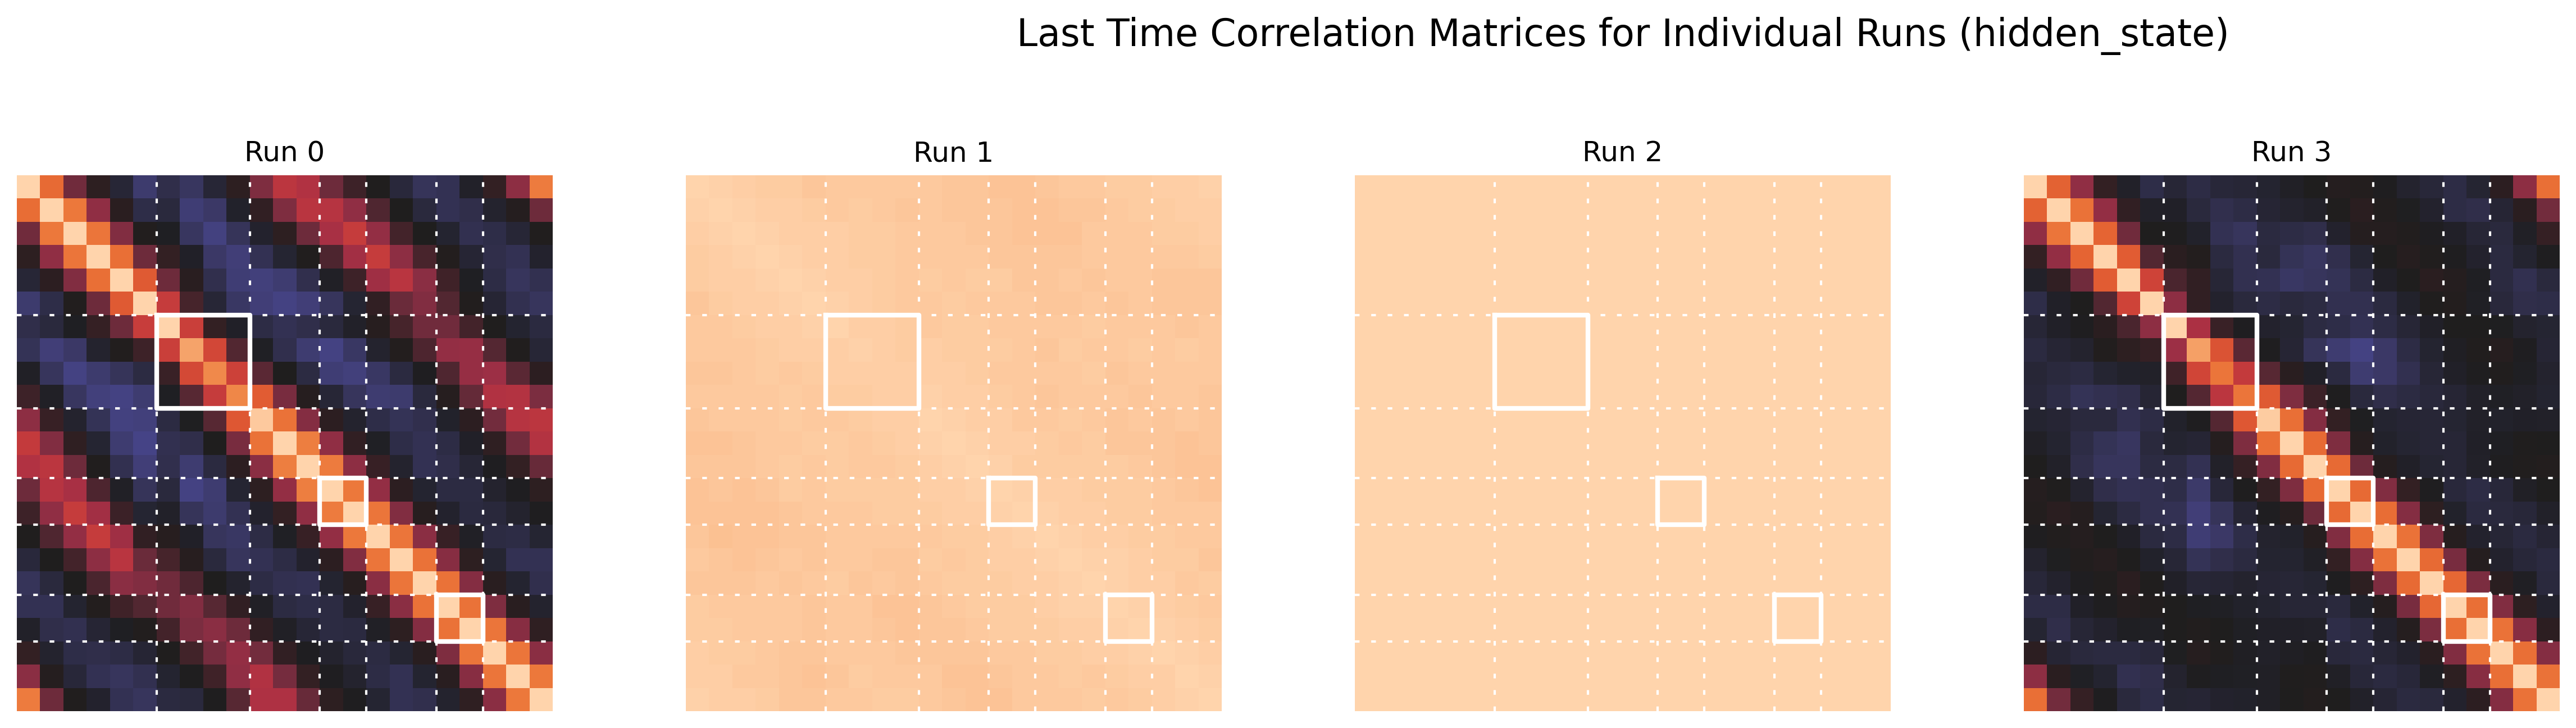

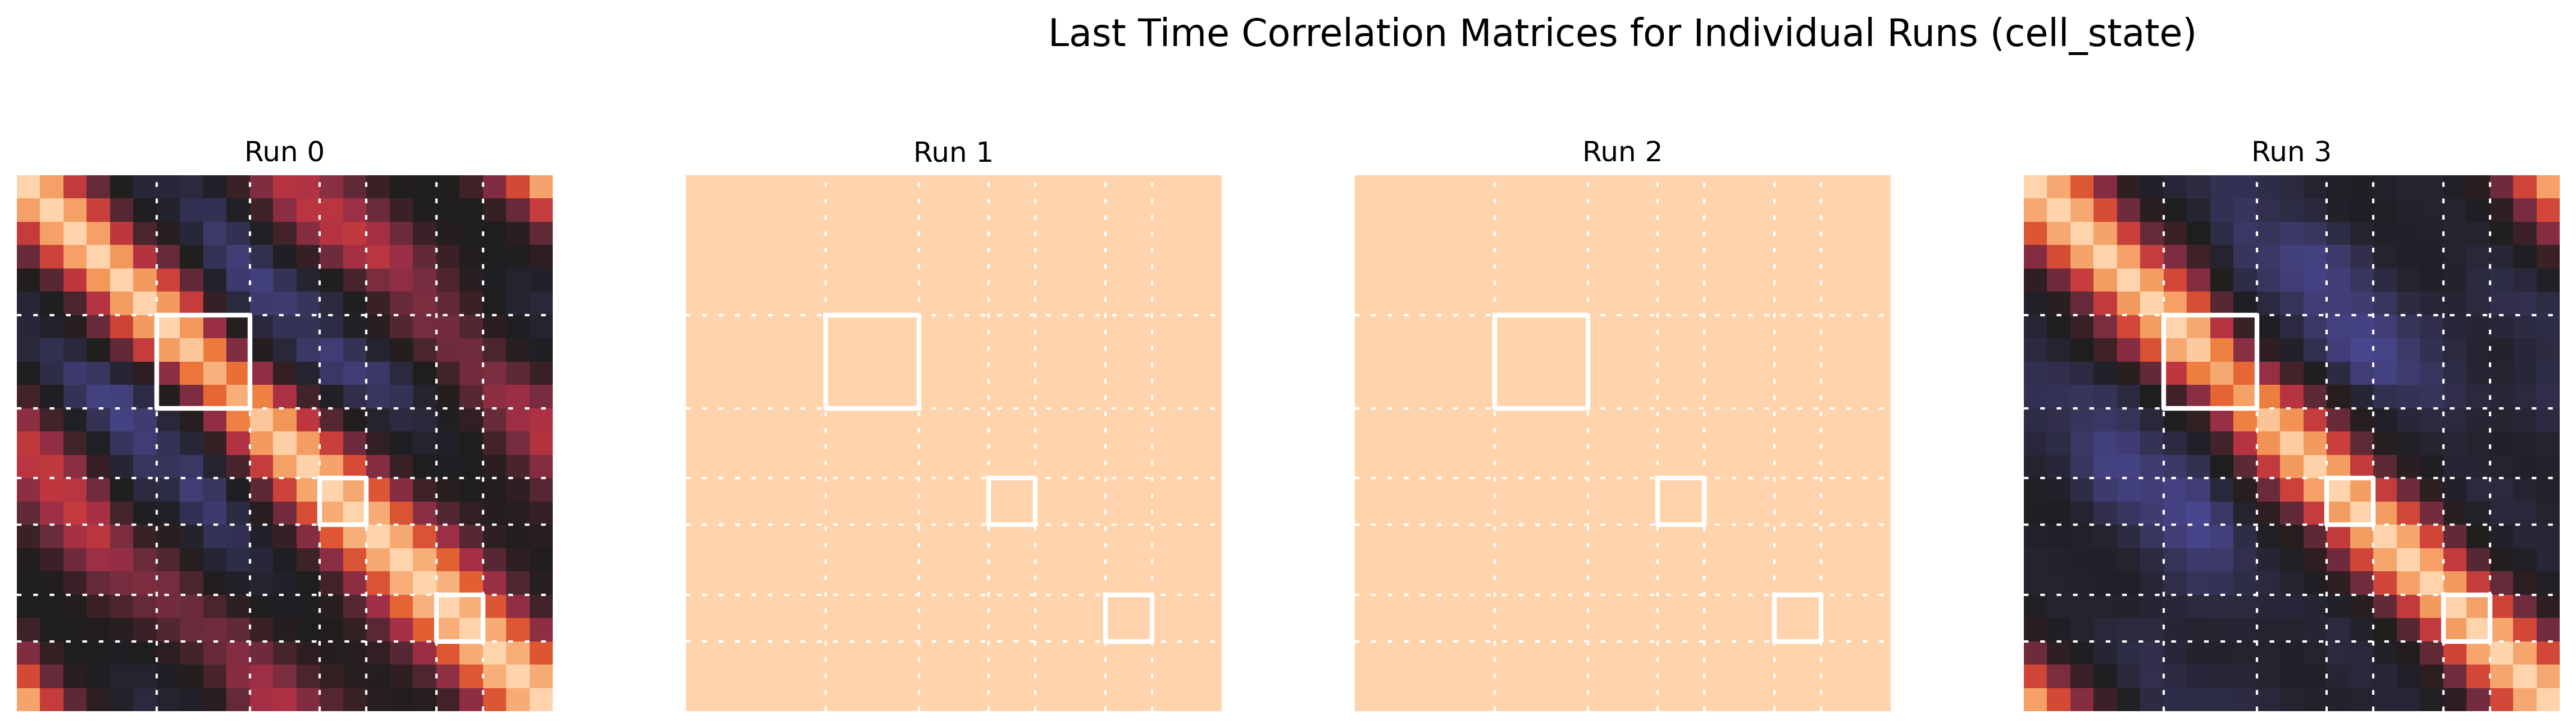

Individual correlation matrices plotted for hidden and cell states.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_individual_correlations(corr_curve, state_name, good_run_indices):
    num_runs = len(good_run_indices)
    fig, axs = plt.subplots(2, 5, figsize=(20, 8), dpi=300)
    fig.suptitle(f'Last Time Correlation Matrices for Individual Runs ({state_name})', fontsize=16)

    for i, run_idx in enumerate(good_run_indices[:10]):  # Plot first 10 runs or less
        row = i // 5
        col = i % 5
        last_frame = corr_curve[run_idx, -1, :tr_len, tr_len:]
        
        sns.heatmap(last_frame, cmap='icefire', vmin=-1, vmax=1, ax=axs[row, col], 
                    cbar=False, xticklabels=False, yticklabels=False, linewidths=0)
        axs[row, col].set_aspect('equal')
        axs[row, col].set_title(f'Run {run_idx}')
        
        for lines in [6, 10, 13, 15, 18, 20]:  
            axs[row, col].axvline(lines, linestyle=(0, (2, 5)), color='white', linewidth=1)
            axs[row, col].axhline(lines, linestyle=(0, (2, 5)), color='white', linewidth=1)
        for (low, high) in [(6, 10), (13, 15), (18, 20)]:
            axs[row, col].plot([low, high, high, low, low], [low, low, high, high, low], color='white', linewidth=2)

    # Hide any unused subplots
    for i in range(num_runs, 10):
        row = i // 5
        col = i % 5
        fig.delaxes(axs[row, col])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #plt.savefig(f'LSTM_RNN_{state_name}_individual_corr_plot.pdf', format='pdf', dpi=300)
    plt.show()

# Plot individual correlation matrices for hidden state
plot_individual_correlations(hidden_corr_curve, "hidden_state", good_run_indices)

# Plot individual correlation matrices for cell state
plot_individual_correlations(cell_corr_curve, "cell_state", good_run_indices)

print("Individual correlation matrices plotted for hidden and cell states.")